Загрузка MNIST...
Данные: (60000, 28, 28, 1)
Генератор создан
Критик создан
WGAN-GP модель создана
Начинаем обучение WGAN-GP...
Эпоха 0 [C loss: 7.7322, W loss: -0.3535, GP: 0.8086] [G loss: 0.1142]
Сохранение изображений для эпохи 0
Эпоха 100 [C loss: -5.8216, W loss: -6.6116, GP: 0.0790] [G loss: -15.5233]
Сохранение изображений для эпохи 100
Эпоха 200 [C loss: -0.0923, W loss: -0.1069, GP: 0.0015] [G loss: -14.0086]
Сохранение изображений для эпохи 200
Эпоха 300 [C loss: -0.8739, W loss: -0.9149, GP: 0.0041] [G loss: -1.2830]
Сохранение изображений для эпохи 300
Эпоха 400 [C loss: -1.0392, W loss: -1.0720, GP: 0.0033] [G loss: -0.8659]
Сохранение изображений для эпохи 400
Эпоха 500 [C loss: -1.8501, W loss: -1.9503, GP: 0.0100] [G loss: -4.6561]
Сохранение изображений для эпохи 500
Эпоха 600 [C loss: -2.8938, W loss: -3.0093, GP: 0.0116] [G loss: 4.7160]
Сохранение изображений для эпохи 600
Эпоха 700 [C loss: -2.2148, W loss: -2.5061, GP: 0.0291] [G loss: 12.3583]
Сохранение изображ

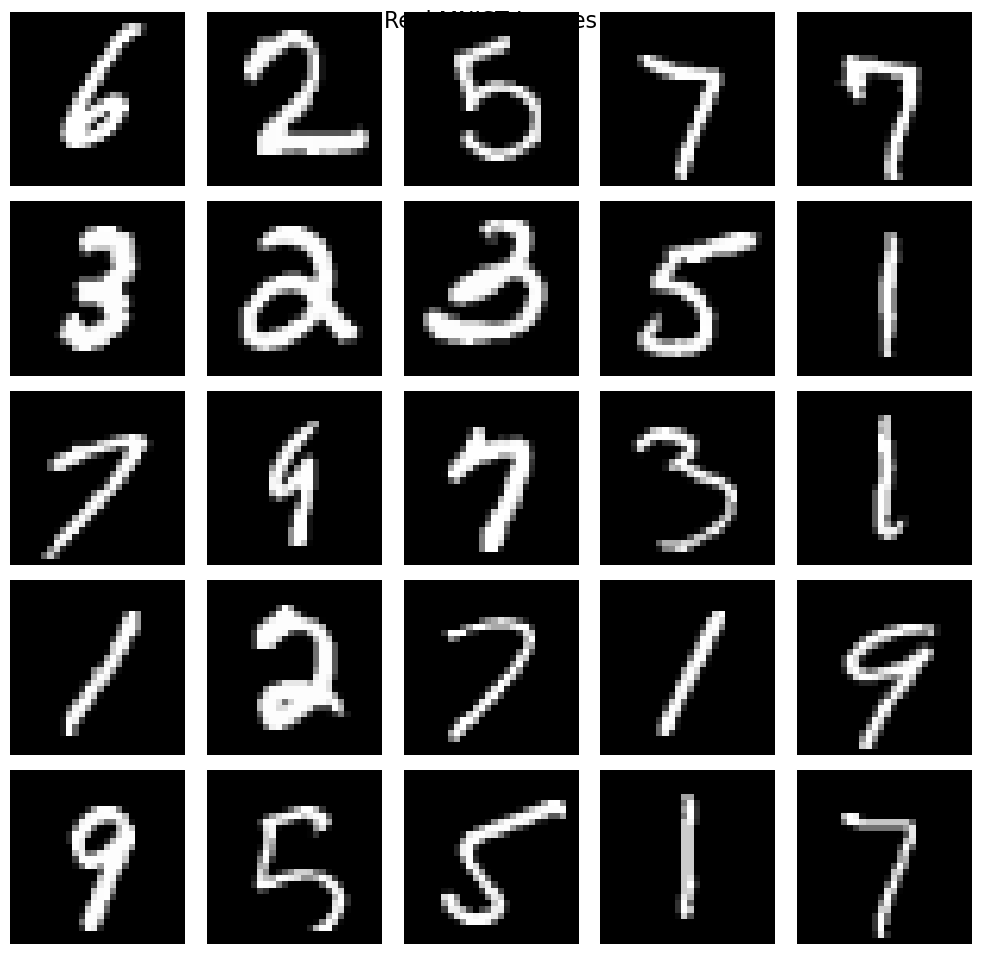


Всего уникальных групп сгенерированных изображений: 10


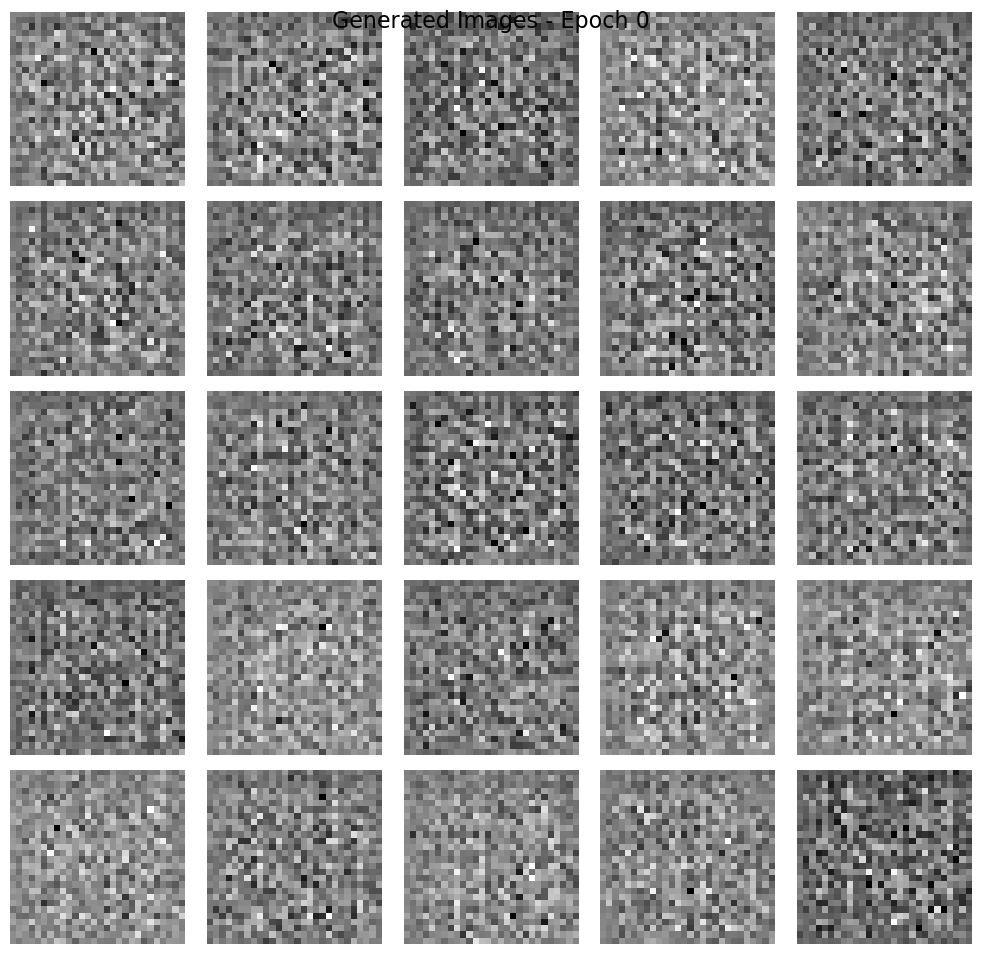

Группа 1: Generated Images - Epoch 0


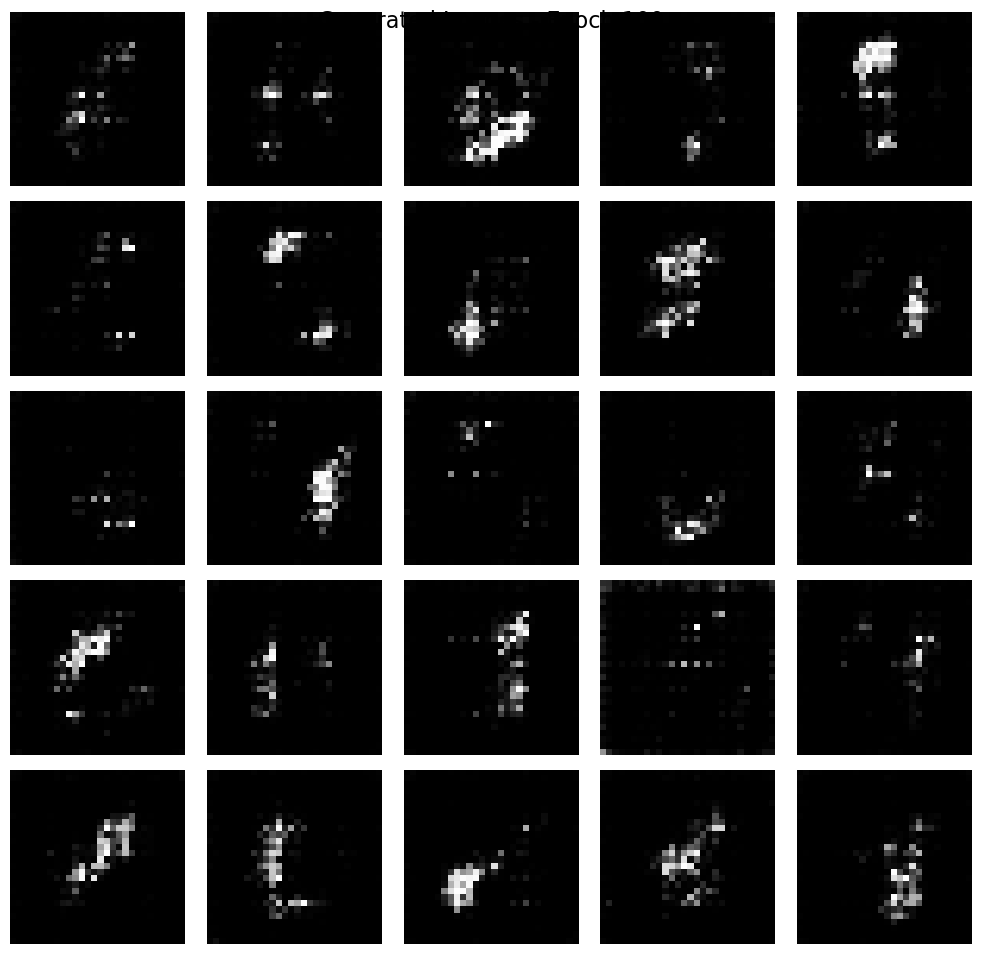

Группа 2: Generated Images - Epoch 100


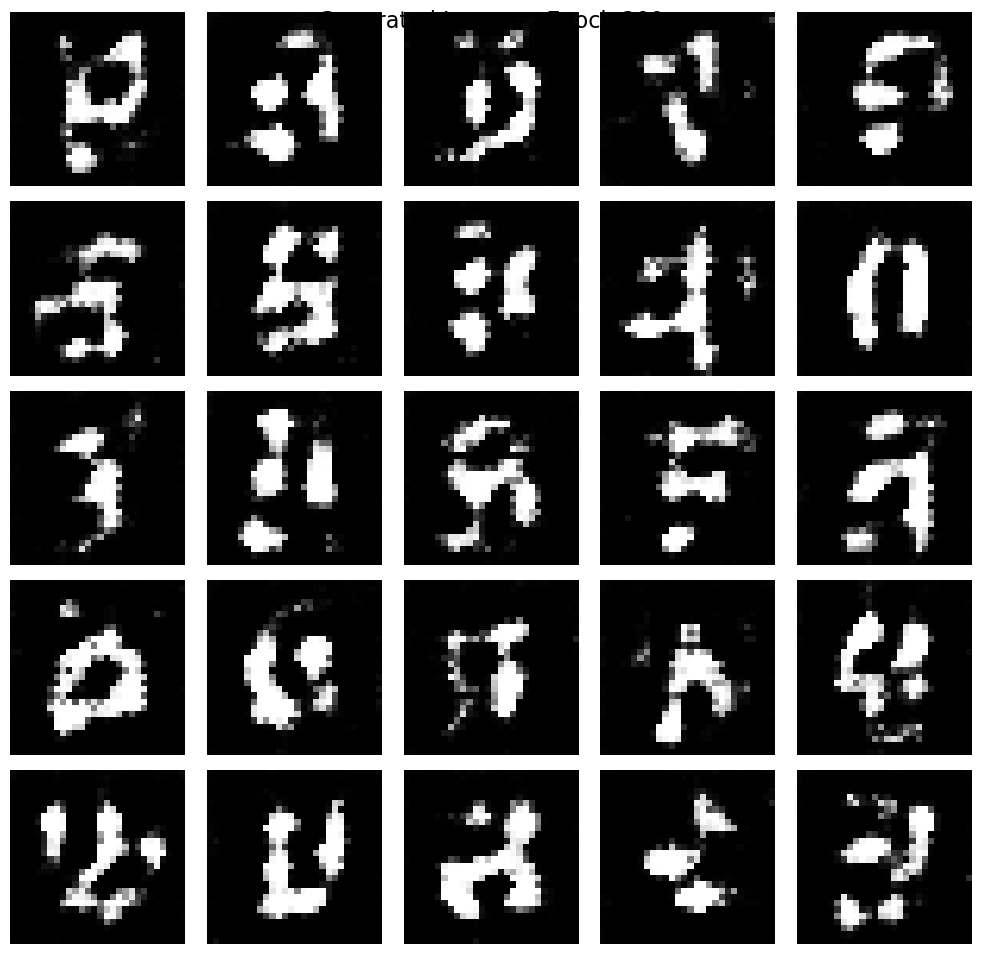

Группа 3: Generated Images - Epoch 200


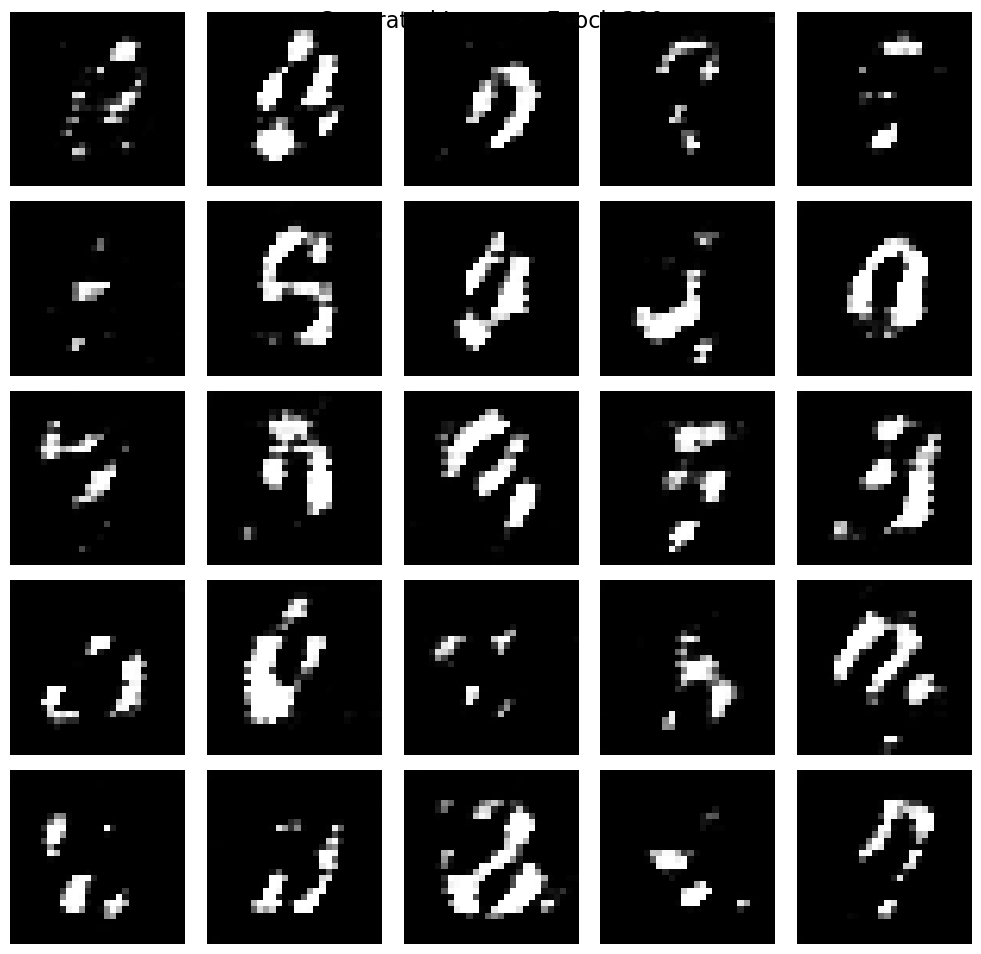

Группа 4: Generated Images - Epoch 300


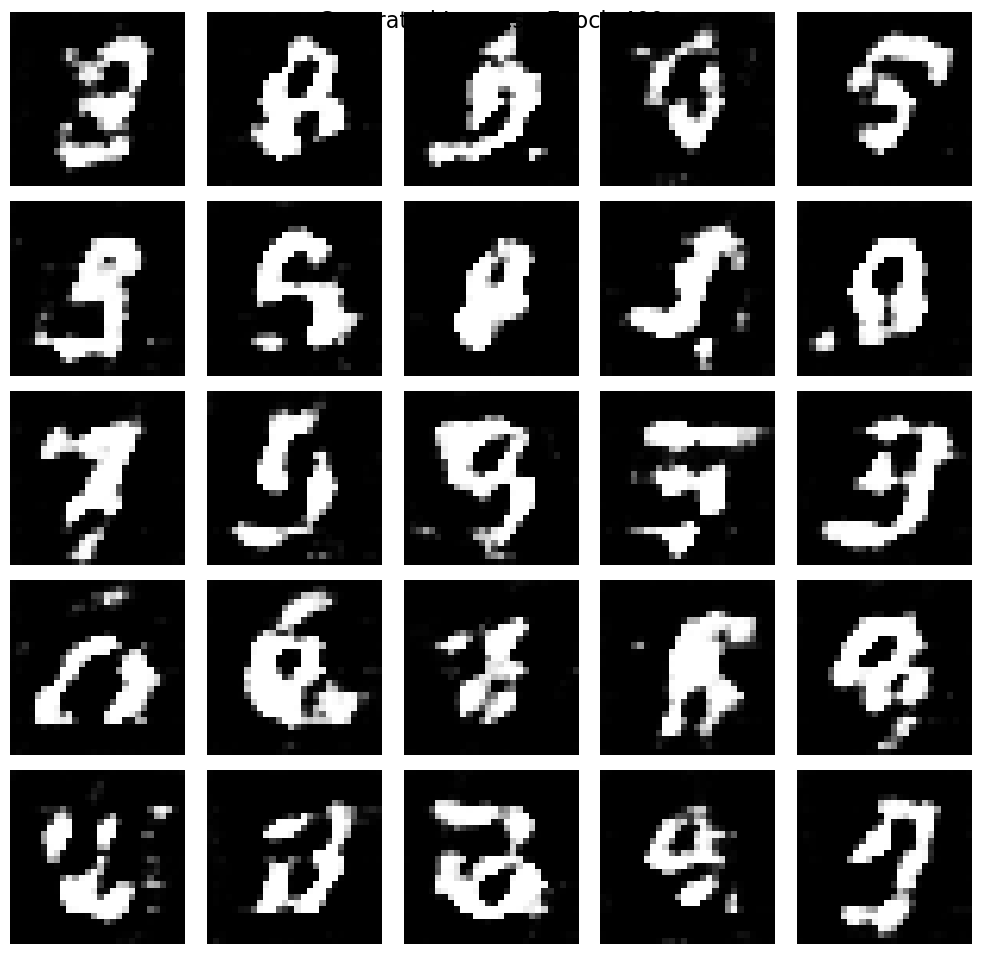

Группа 5: Generated Images - Epoch 400


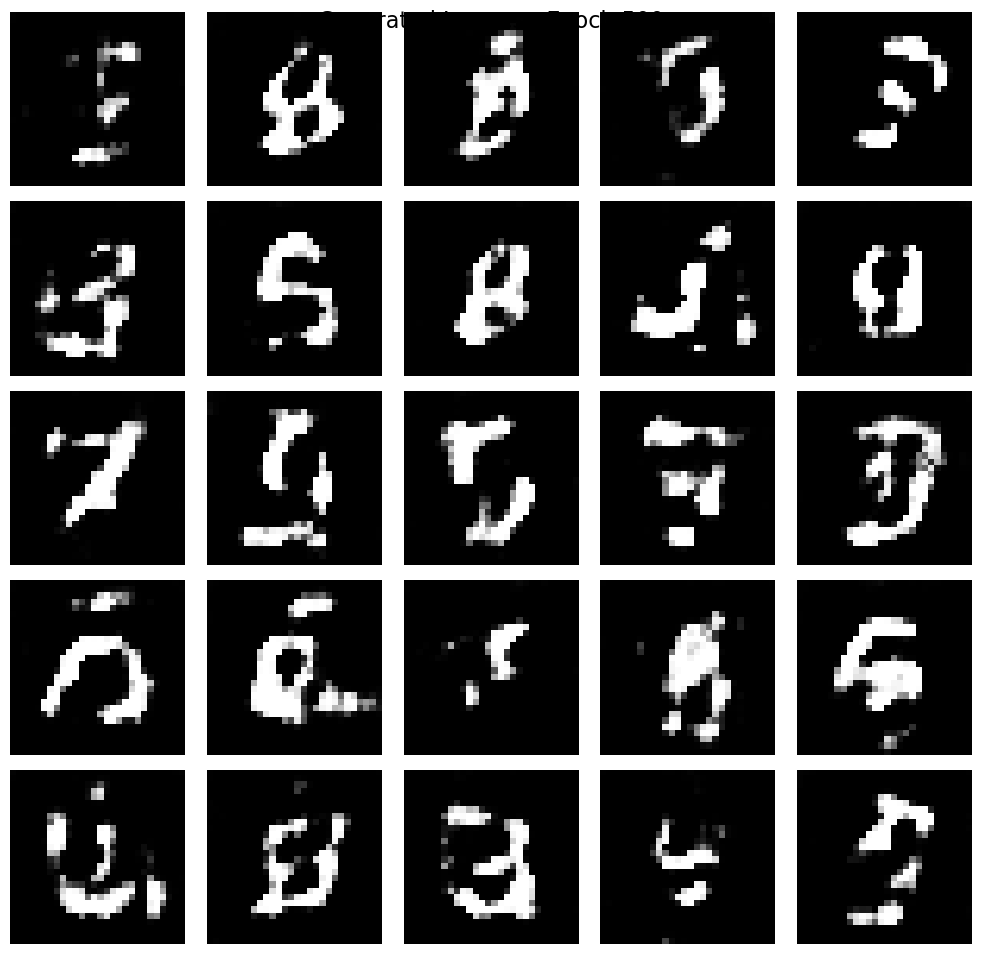

Группа 6: Generated Images - Epoch 500


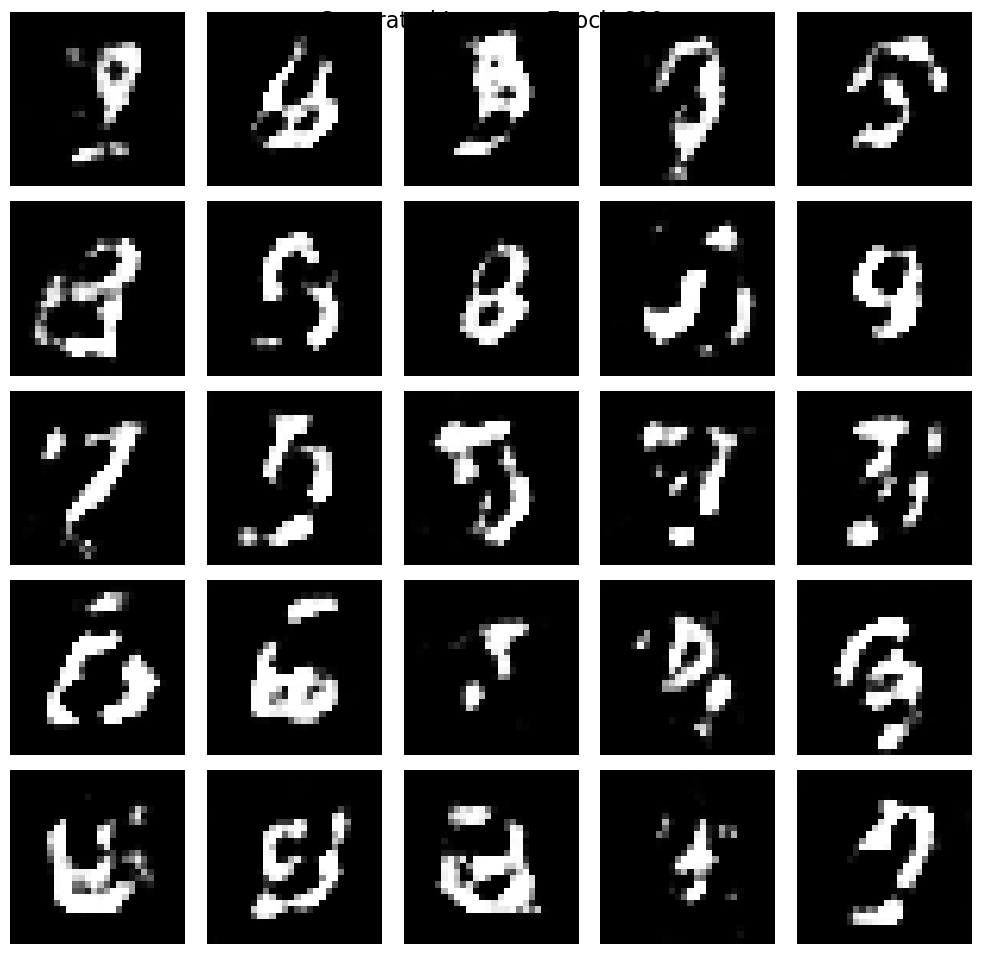

Группа 7: Generated Images - Epoch 600


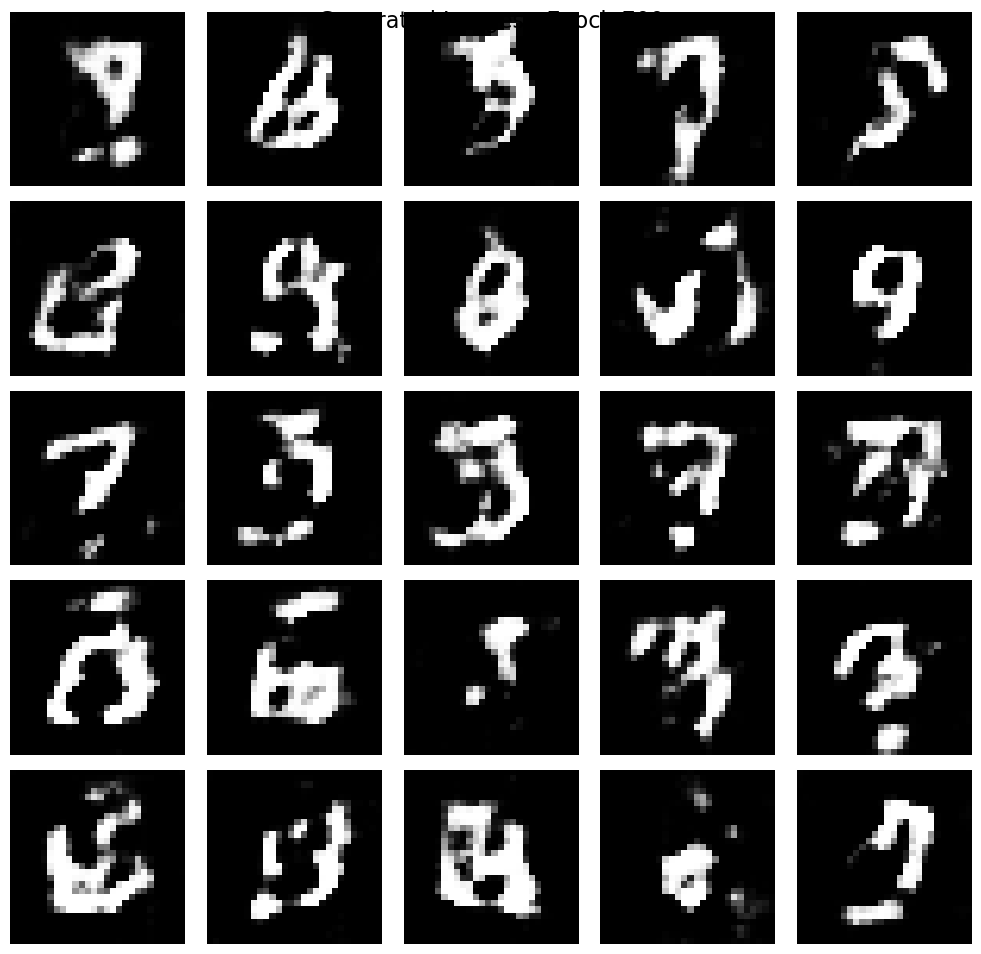

Группа 8: Generated Images - Epoch 700


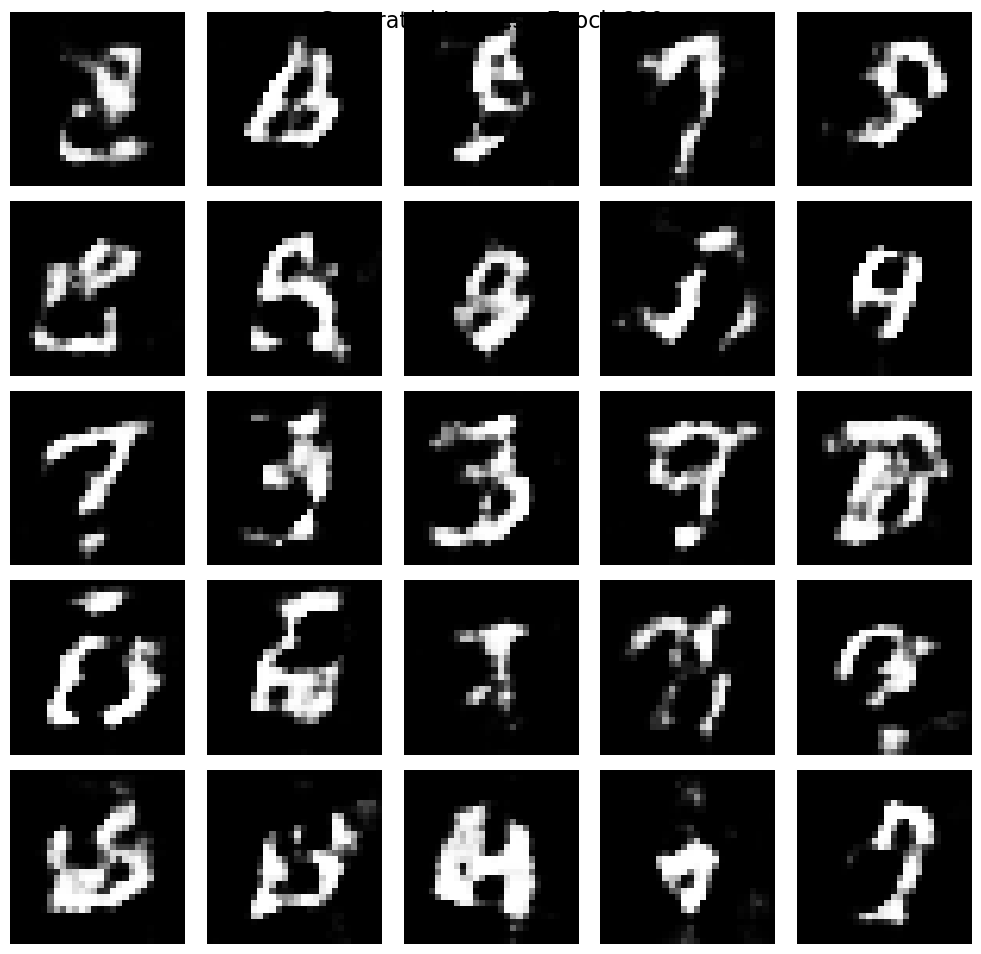

Группа 9: Generated Images - Epoch 800


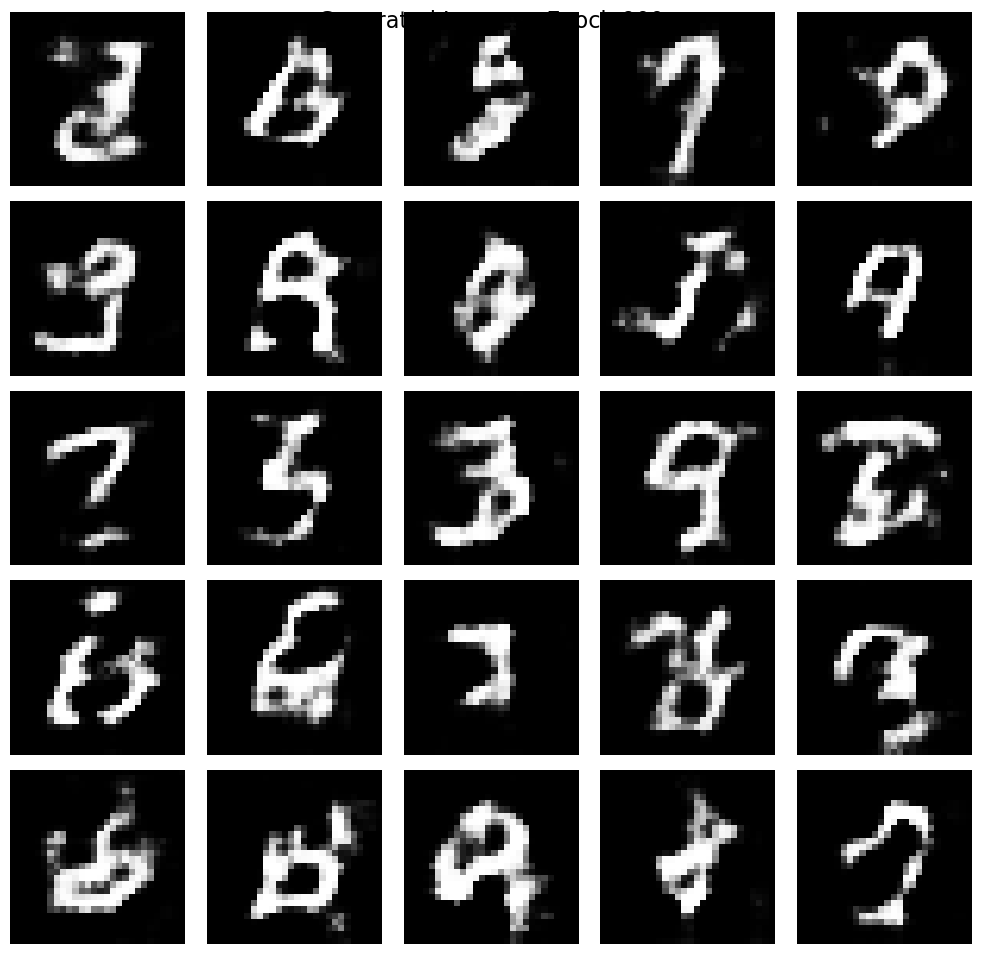

Группа 10: Generated Images - Epoch 900

=== ПРЯМОЕ СРАВНЕНИЕ РЯДАМИ ===


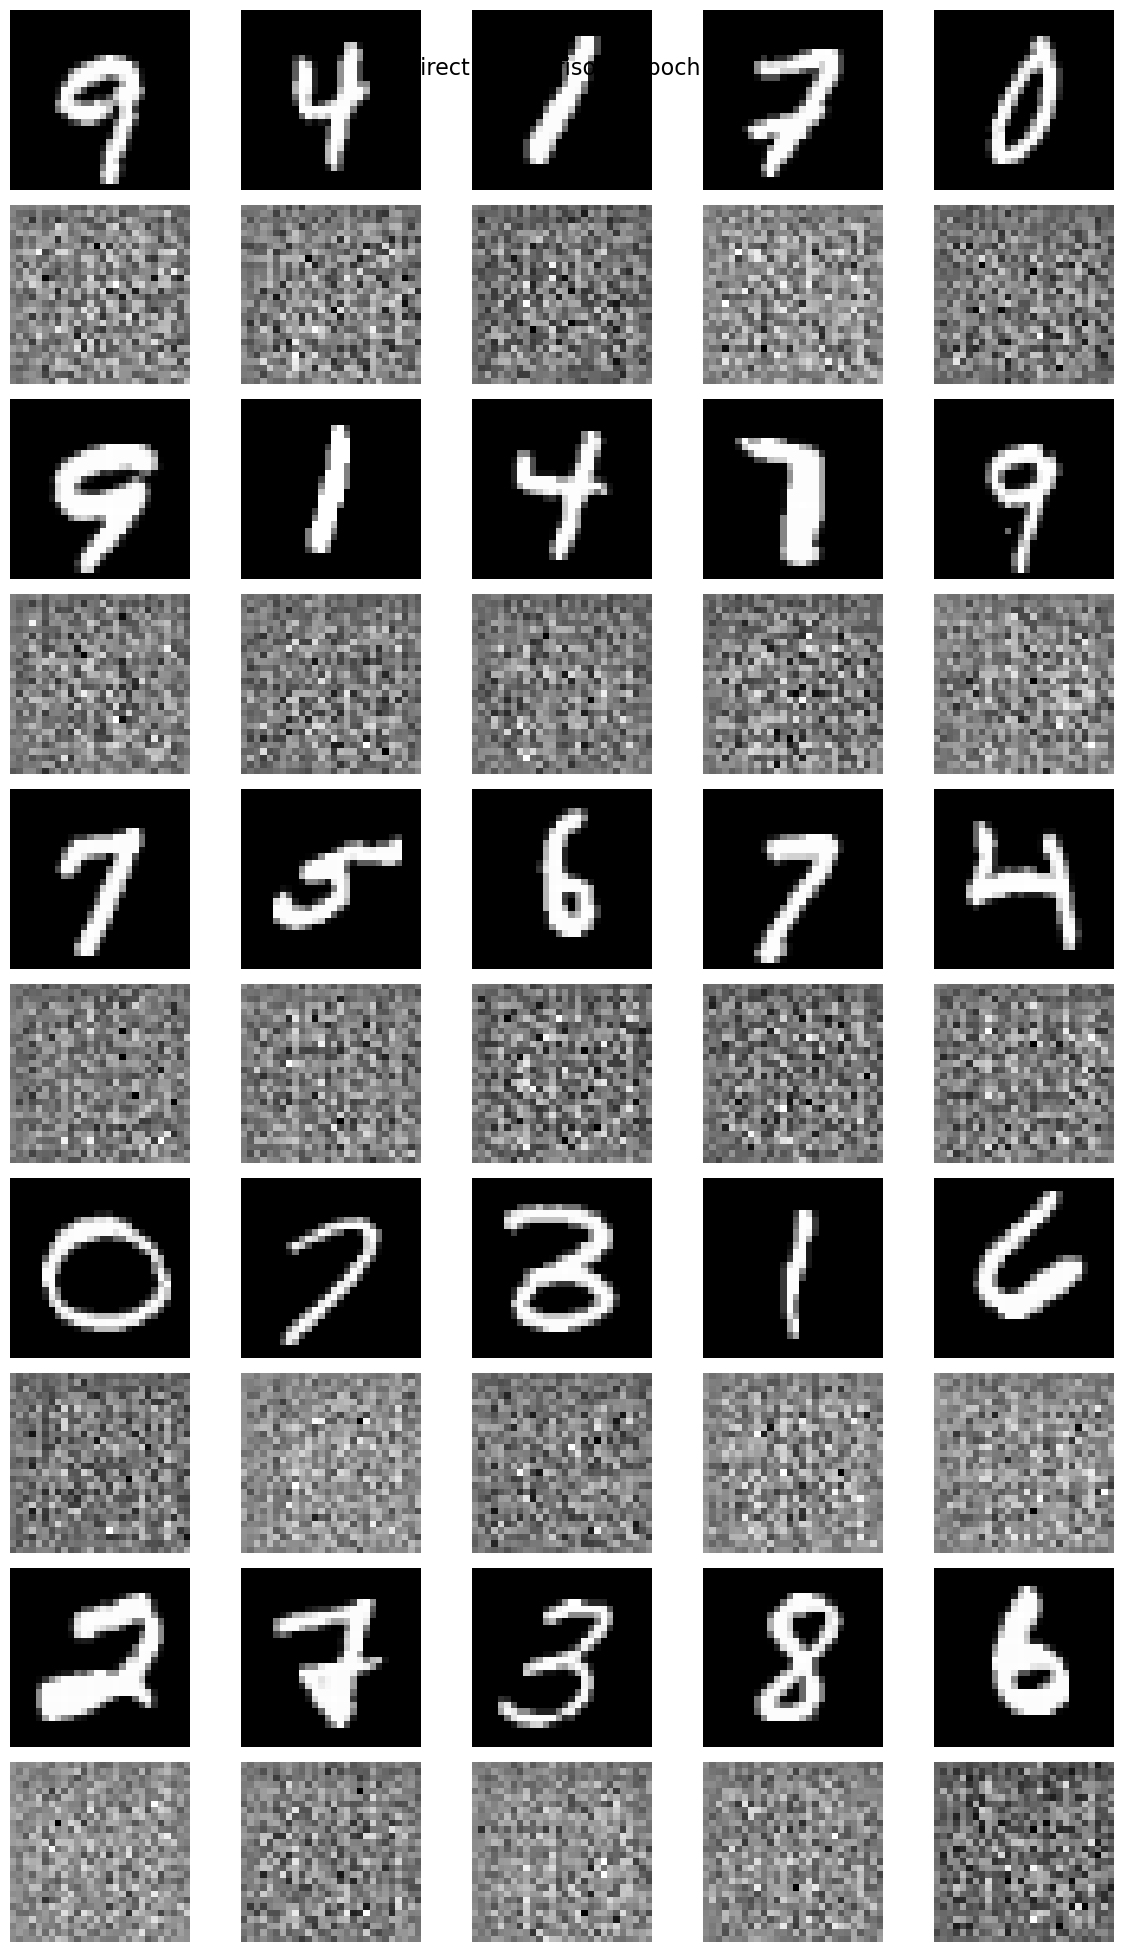

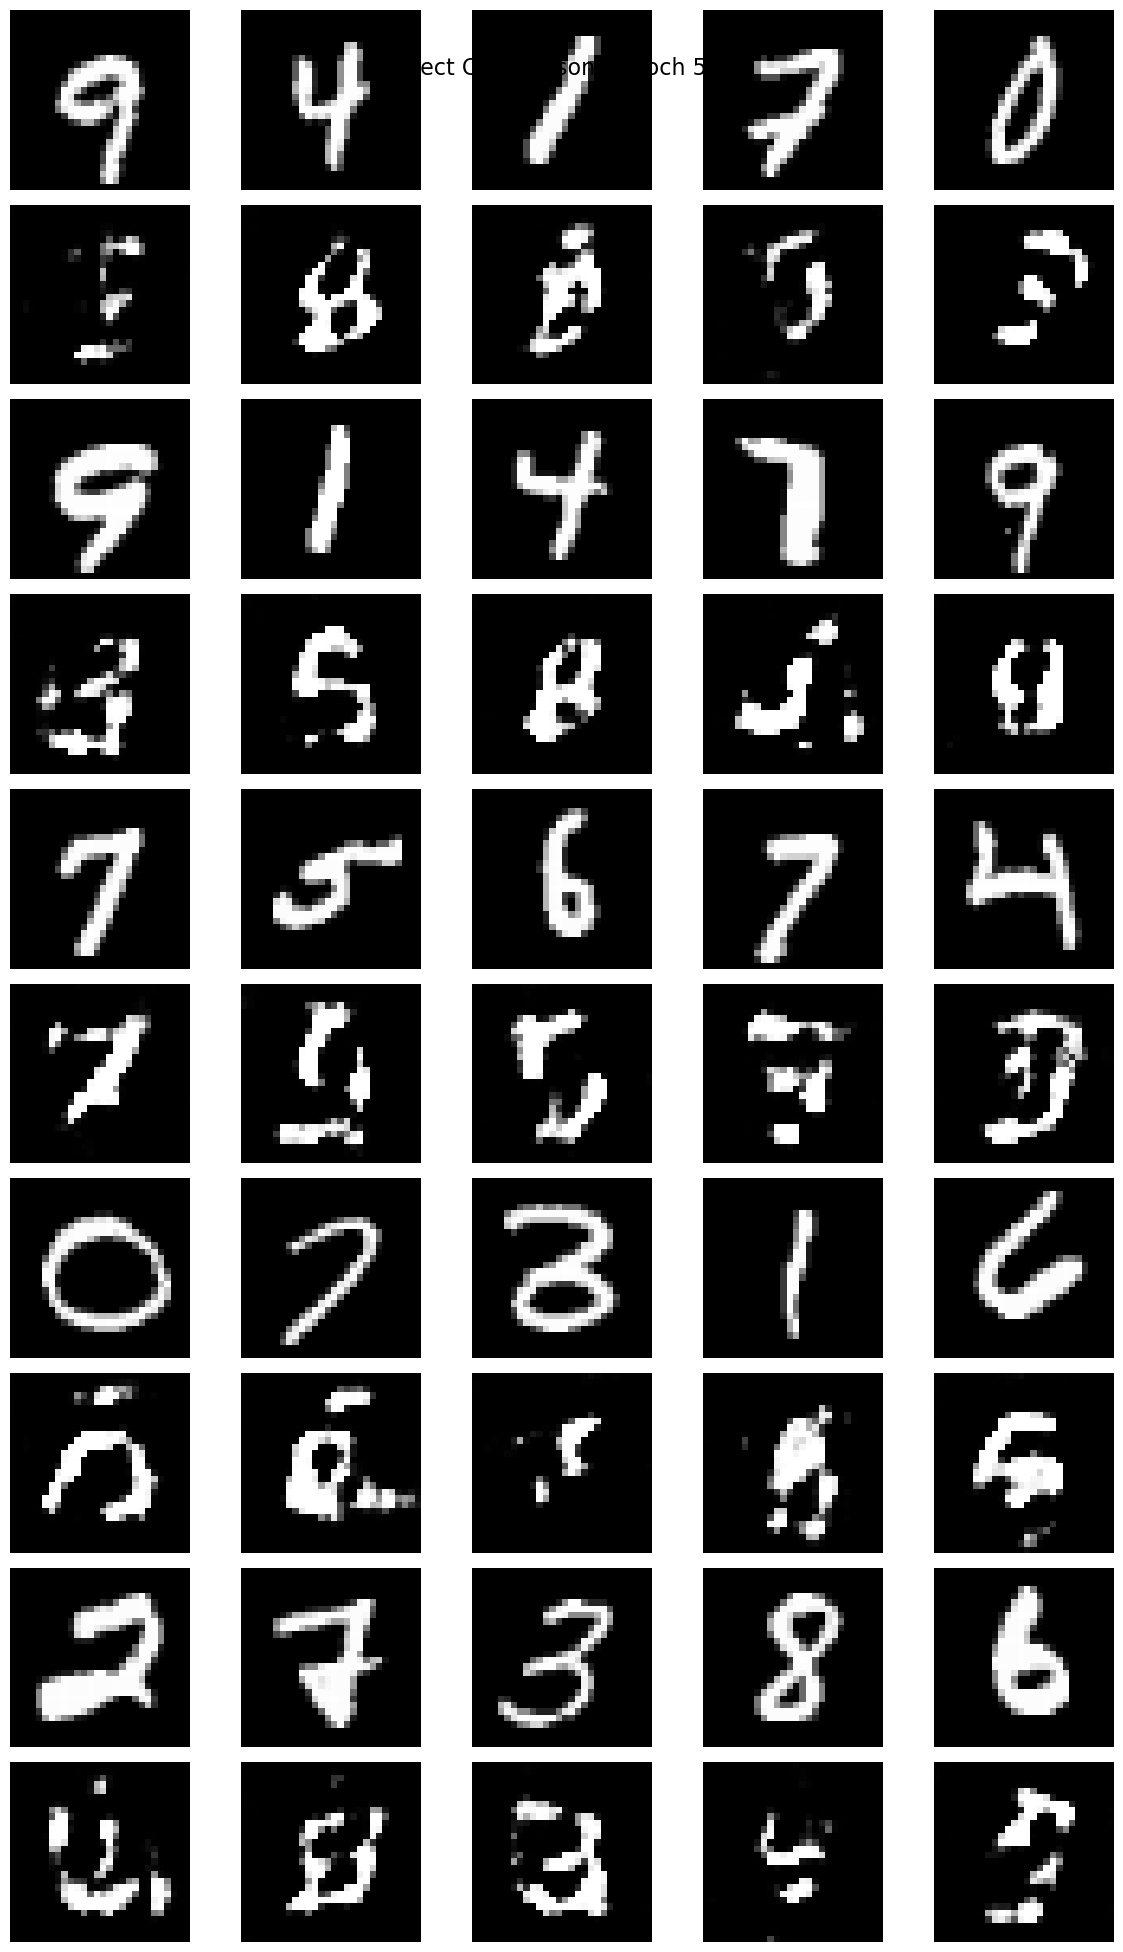

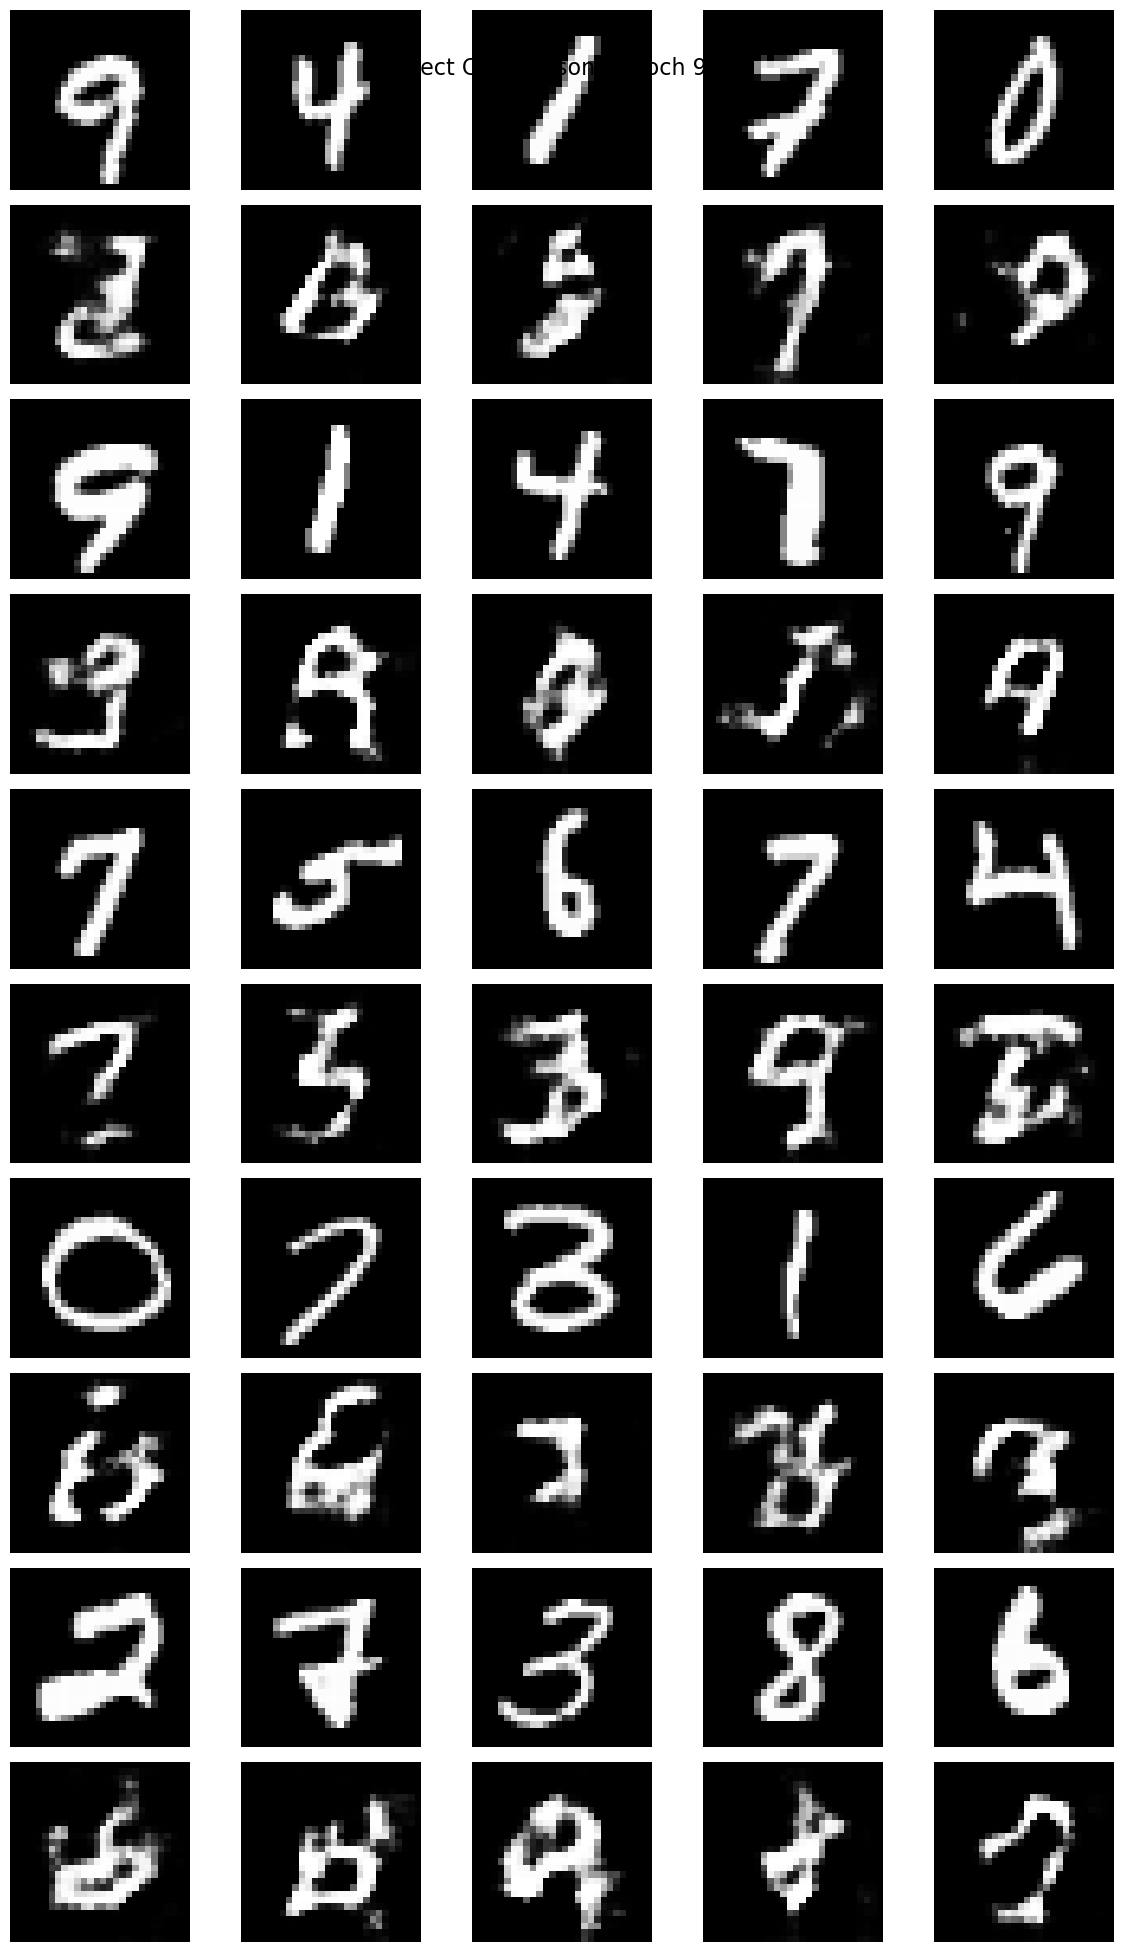


=== WGAN-GP ОБУЧЕНИЕ ЗАВЕРШЕНО ===


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K
from collections import defaultdict

# Фиксируем семена
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

def save_epoch_images(epoch, generator, examples=25):
    """Сохраняет сгенерированные изображения для конкретной эпохи"""
    # Генерируем изображения из фиксированного шума для воспроизводимости
    fixed_noise = np.random.RandomState(42).normal(0, 1, (examples, 100))
    generated_images = generator.predict(fixed_noise, verbose=0)
    generated_images = 0.5 * generated_images + 0.5  # Денормализуем
    
    return generated_images

def find_duplicate_epochs(epoch_images):
    """Находит дубликаты среди изображений разных эпох"""
    # Создаем хеш для каждого набора изображений
    image_hashes = {}
    for epoch, images in epoch_images.items():
        # Создаем хеш на основе среднего значения пикселей
        img_hash = hash(tuple(images.flatten().round(3)))
        image_hashes[epoch] = img_hash
    
    # Группируем эпохи по хешам
    hash_to_epochs = defaultdict(list)
    for epoch, img_hash in image_hashes.items():
        hash_to_epochs[img_hash].append(epoch)
    
    return hash_to_epochs

def display_comparison_5x5(epoch_images, hash_to_epochs, real_images):
    """Отображает сравнение реальных и сгенерированных изображений в формате 5x5"""
    
    # Показываем реальные изображения
    print("=== РЕАЛЬНЫЕ ИЗОБРАЖЕНИЯ MNIST ===")
    plt.figure(figsize=(10, 10))
    
    # Выбираем 25 случайных реальных изображений
    idx = np.random.randint(0, real_images.shape[0], 25)
    real_samples = real_images[idx]
    real_samples = 0.5 * real_samples + 0.5  # Денормализуем
    
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(real_samples[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.suptitle('Real MNIST Images', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Сортируем группы по минимальной эпохе в группе
    sorted_groups = sorted(hash_to_epochs.values(), key=lambda x: min(x))
    
    print(f"\nВсего уникальных групп сгенерированных изображений: {len(sorted_groups)}")
    
    # Показываем сгенерированные изображения по группам
    for group_idx, epoch_group in enumerate(sorted_groups):
        # Берем изображения из первой эпохи в группе (они одинаковые)
        first_epoch = min(epoch_group)
        images = epoch_images[first_epoch]
        
        # СОЗДАЕМ ВИЗУАЛИЗАЦИЮ 5x5
        plt.figure(figsize=(10, 10))
        
        # Отображаем все 25 изображений в сетке 5x5
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.imshow(images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        
        # Формируем заголовок
        if len(epoch_group) == 1:
            title = f'Generated Images - Epoch {epoch_group[0]}'
        else:
            title = f'Generated Images - Epochs {min(epoch_group)}-{max(epoch_group)}'
        
        plt.suptitle(title, fontsize=16, y=0.95)
        plt.tight_layout()
        plt.show()
        
        print(f"Группа {group_idx + 1}: {title}")

def display_side_by_side_comparison(epoch_images, hash_to_epochs, real_images, num_comparisons=3):
    """Показывает прямое сравнение реальных и сгенерированных изображений"""
    
    # Выбираем несколько самых интересных групп (первые, средние и последние)
    sorted_groups = sorted(hash_to_epochs.values(), key=lambda x: min(x))
    
    # Выбираем группы для сравнения
    if len(sorted_groups) <= num_comparisons:
        selected_groups = sorted_groups
    else:
        # Берем первую, среднюю и последнюю группы
        selected_groups = [
            sorted_groups[0],
            sorted_groups[len(sorted_groups) // 2],
            sorted_groups[-1]
        ]
    
    # Выбираем реальные изображения
    idx = np.random.randint(0, real_images.shape[0], 25)
    real_samples = real_images[idx]
    real_samples = 0.5 * real_samples + 0.5
    
    for group in selected_groups:
        first_epoch = min(group)
        generated_images = epoch_images[first_epoch]
        
        # Создаем фигуру для сравнения
        fig, axes = plt.subplots(10, 5, figsize=(12, 20))
        
        for i in range(5):
            for j in range(5):
                # Реальные изображения (верхний ряд)
                axes[i*2, j].imshow(real_samples[i*5 + j, :, :, 0], cmap='gray')
                axes[i*2, j].axis('off')
                
                # Сгенерированные изображения (нижний ряд)
                axes[i*2 + 1, j].imshow(generated_images[i*5 + j, :, :, 0], cmap='gray')
                axes[i*2 + 1, j].axis('off')
        
        # Добавляем подписи
        for i in range(5):
            axes[i*2, 0].set_ylabel(f'Real\nRow {i+1}', rotation=0, ha='right', va='center')
            axes[i*2 + 1, 0].set_ylabel(f'Generated\nRow {i+1}', rotation=0, ha='right', va='center')
        
        if len(group) == 1:
            title = f'Direct Comparison - Epoch {group[0]}'
        else:
            title = f'Direct Comparison - Epochs {min(group)}-{max(group)}'
        
        plt.suptitle(title, fontsize=16, y=0.95)
        plt.tight_layout()
        plt.show()

# Загрузка данных
print("Загрузка MNIST...")
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(f"Данные: {X_train.shape}")

# WGAN-GP Generator
def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    
    # Upsample to 14x14
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 28x28
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Output layer
    model.add(tf.keras.layers.Conv2D(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
    
    print("Генератор создан")
    return model

# WGAN-GP Critic (вместо Discriminator)
def build_critic():
    model = Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))  # No activation for WGAN
    
    print("Критик создан")
    return model

# Gradient Penalty для WGAN-GP
def gradient_penalty_loss(critic, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    
    # Интерполированные изображения
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        interpolated_output = critic(interpolated)
    
    gradients = tape.gradient(interpolated_output, interpolated)
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
    
    return gradient_penalty

# Создаем модели
generator = build_generator()
critic = build_critic()

# Оптимизаторы для WGAN-GP
generator_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
critic_optimizer = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

print("WGAN-GP модель создана")

# Параметры обучения WGAN-GP
epochs = 1000  # Уменьшим для демонстрации
batch_size = 64
n_critic = 5
lambda_gp = 10

# Для отслеживания прогресса
g_losses = []
c_losses = []

print("Начинаем обучение WGAN-GP...")

@tf.function
def train_critic(real_images):
    batch_size = tf.shape(real_images)[0]
    
    # Генерируем шум
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as tape:
        # Генерируем поддельные изображения
        fake_images = generator(noise, training=True)
        
        # Предсказания критика
        real_output = critic(real_images, training=True)
        fake_output = critic(fake_images, training=True)
        
        # Wasserstein loss
        wasserstein_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
        
        # Gradient penalty
        gp = gradient_penalty_loss(critic, real_images, fake_images)
        
        # Общий loss критика
        critic_loss = wasserstein_loss + lambda_gp * gp
    
    # Применяем градиенты
    gradients = tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))
    
    return critic_loss, wasserstein_loss, gp

@tf.function
def train_generator():
    batch_size = 64
    
    with tf.GradientTape() as tape:
        # Генерируем шум
        noise = tf.random.normal([batch_size, 100])
        
        # Генерируем изображения
        fake_images = generator(noise, training=True)
        
        # Предсказания критика
        fake_output = critic(fake_images, training=True)
        
        # Loss генератора (отрицательный, так как хотим максимизировать оценку критика)
        generator_loss = -tf.reduce_mean(fake_output)
    
    # Применяем градиенты
    gradients = tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    
    return generator_loss

# Словарь для хранения изображений по эпохам
epoch_images = {}

# Основной цикл обучения WGAN-GP
for epoch in range(epochs):
    
    # Обучаем критика n_critic раз
    for _ in range(n_critic):
        # Выбираем случайные реальные изображения
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        
        critic_loss, wasserstein_loss, gp = train_critic(real_imgs)
        c_losses.append(critic_loss.numpy())
    
    # Обучаем генератор один раз
    generator_loss = train_generator()
    g_losses.append(generator_loss.numpy())
    
    # Показываем прогресс
    if epoch % 100 == 0:
        print(f"Эпоха {epoch} [C loss: {critic_loss:.4f}, W loss: {wasserstein_loss:.4f}, GP: {gp:.4f}] [G loss: {generator_loss:.4f}]")
    
    # Сохраняем изображения для анализа каждые 100 эпох
    if epoch % 100 == 0:
        print(f"Сохранение изображений для эпохи {epoch}")
        epoch_images[epoch] = save_epoch_images(epoch, generator, examples=25)

# После обучения анализируем и группируем изображения
print("\n=== АНАЛИЗ И ГРУППИРОВКА ИЗОБРАЖЕНИЙ ПО ЭПОХАМ ===")

# Находим дубликаты
hash_to_epochs = find_duplicate_epochs(epoch_images)

print("Группировка эпох по одинаковости изображений:")
for img_hash, epochs_list in hash_to_epochs.items():
    epochs_list.sort()
    if len(epochs_list) == 1:
        print(f"  Уникальные: эпоха {epochs_list[0]}")
    else:
        print(f"  Одинаковые: эпохи {epochs_list[0]}-{epochs_list[-1]}")

# Отображаем сравнение реальных и сгенерированных изображений
print("\n=== СРАВНЕНИЕ РЕАЛЬНЫХ И СГЕНЕРИРОВАННЫХ ИЗОБРАЖЕНИЙ ===")
display_comparison_5x5(epoch_images, hash_to_epochs, X_train)

print("\n=== ПРЯМОЕ СРАВНЕНИЕ РЯДАМИ ===")
display_side_by_side_comparison(epoch_images, hash_to_epochs, X_train)

print("\n=== WGAN-GP ОБУЧЕНИЕ ЗАВЕРШЕНО ===")